In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import unicodedata

import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

- categoryは全部one-hotで表現
- yaerで2030年以降のものがある
    - おそらくタイポ
    - -1000してあげるのが良い
    - lightgbm使うのでその他の処理は行わない
- conditionは1~6で評価
- odometer
    - 絶対値を取る
    - 1はnullにしてあげる(元々odometer=1のデータはない)
    - 1e6を超える場合は10で割る
- cylinders, transmission, typeのotherはnullにする

In [58]:
def preprocess(df):
    #year
    df.loc[((df['year']>2030) & (df['year']<3000)) | (df['year']>=3000), 'year'] -= 1000

    #condition
    condition_dict = {'excellent':4, 'fair':2, 'good':3, 'like new':5, 'salvage':1, 'new':6}
    df['condition'] = df['condition'].apply(lambda x: condition_dict[x])

    #odometer
    def set_odometer(x):
        x = abs(x)
        if x==1:
            return None
        if x>1e6:
            x = x//10
        return x
    df['odometer'] = [set_odometer(x) for x in df['odometer'].values]

    #size
    size_dict = {'mid-size':3, 'full-size':4, 'sub-compact':1, 'compact':2}
    df['size'] = [size_dict[unicodedata.normalize('NFKC', x).lower().replace('ー', '-').replace('−', '-')] if type(x)==str else None for x in df['size'].values]

    #categorical data
    categoly_calumns = ['region', 'manufacturer', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']
    for cat in categoly_calumns:
        df[cat] = [unicodedata.normalize('NFKC', x).lower() if type(x)==str else None for x in df[cat].values]

    #otherをnullにする
    for cat in ['cylinders', 'transmission', 'type']:
        df[cat] = [x if x!='other' else None for x in df[cat].values]

    df = pd.get_dummies(df, columns=categoly_calumns) #one-hot vectorize

    df['odometer'] = df['odometer'].fillna(df['odometer'].mean())
    
    for cat in df.columns:
        if len(df[df[cat].isnull()]) == 0:
            df[cat] = df[cat].astype(int) 
    return df

In [59]:
df = pd.concat([train, test], ignore_index=True).drop(['price'], axis=1)
df_processed = preprocess(df)
df_processed.head()

,year,condition,odometer,size,region_abilene,region_akron / canton,region_albany,region_albuquerque,region_altoona-johnstown,region_amarillo,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,1949,4,115148,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013,2,172038,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1998,3,152492,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014,4,104118,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2005,4,144554,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
X = df_processed[:len(train)].values
y = train['price'].values
X_test = df_processed[len(train):].values

features = df_processed.columns

In [83]:
n_splits = 4
random_state = 42

folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("Fold {}".format(fold_+1))
    X_train, X_valid = X[trn_idx], X[val_idx]
    y_train, y_valid = y[trn_idx], y[val_idx]
    
    # モデルの構築
    tf.random.set_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(512, activation='relu', input_shape=(1024,)),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation='relu', input_shape=(512,)),
        tf.keras.layers.Dense(128, activation='relu', input_shape=(256,)),
        tf.keras.layers.Dense(128, activation='relu', input_shape=(128,)),
        tf.keras.layers.Dense(64, activation='relu', input_shape=(128,)),
        tf.keras.layers.Dense(16, activation='relu', input_shape=(64,)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10000, batch_size=32, callbacks=[early_stopping])

    oof[val_idx] = model.predict(X_valid).flatten()    
    predictions += model.predict(X_test).flatten() / folds.n_splits

print("CV score: {:<8.5f}".format(mean_absolute_percentage_error(y, oof)))

Fold 1
Epoch 1/10000
646/646 [==============================] - 3s 4ms/step - loss: 61.1326 - val_loss: 54.9044
Epoch 2/10000
646/646 [==============================] - 3s 4ms/step - loss: 53.5586 - val_loss: 51.8289
Epoch 3/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.9511 - val_loss: 51.1566
Epoch 4/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.9873 - val_loss: 51.5263
Epoch 5/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.5522 - val_loss: 52.2536
Epoch 6/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.4306 - val_loss: 51.1546
Epoch 7/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.4982 - val_loss: 54.5120
Epoch 8/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.3064 - val_loss: 51.9182
Epoch 9/10000
646/646 [==============================] - 3s 4ms/step - loss: 52.3284 - val_loss: 51.4841
Epoch 10/10000
646/646 [========================

In [84]:
oof_df = train.copy()
oof_df['oof'] = oof
oof_df.head(5)

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,oof
id,,,,,,,,,,,,,,,,
0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587,5858.745117
1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724,3304.864746
2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931,4112.928223
3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553,6359.284668
4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158,3979.386230


0.4694855439000568


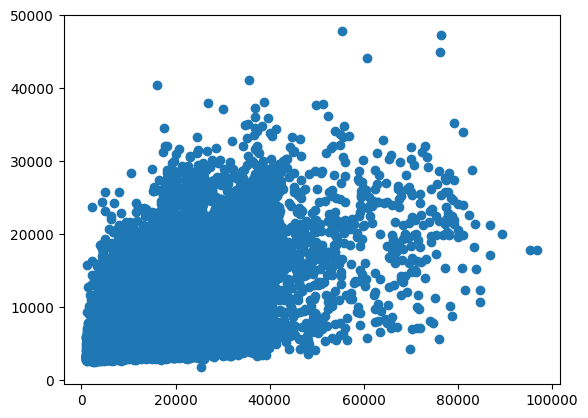

In [85]:
print(mean_absolute_percentage_error(y, oof))
plt.scatter(y, oof)

In [86]:
sub_df = pd.DataFrame({"id":test.index})
sub_df["price"] = predictions
sub_df.to_csv('output/sub003.csv', index=False, header=False)
sub_df

,id,price
0,27532,6961.747925
1,27533,4870.367798
2,27534,5605.261108
3,27535,17531.593750
4,27536,4320.296265
...,...,...
27532,55064,9249.024170
27533,55065,12653.056885
27534,55066,7246.430786
27535,55067,4415.756348
